# Prediccion del resultado de eventos musicales

Se cuenta con un conjunto de 360 eventos realizados el mes de abril en Estados Unidos. Para cada uno de estos eventos se cuenta con el resultado de éstos, a través del número de tickets y el porcentaje de ocupación del lugar del evento. Es este indicador, el porcentaje, el valor que constituirá la variable dependiente del problema.

Para analizar el problema, se buscó contar con un conjunto de variables independientes, que permitieran caracterizar al evento. En primer lugar, se tomaron datos del evento:
    * estado de EEUU
    * día de la semana
    * capacidad del recinto
    * precio del ticket

Por otro lado, se realizó la recopilación de datos de redes sociales, accediendo a las APIs de las redes, para cada uno de los artistas del conjunto. Se comenzó con la recopilación de las redes (los nombres) para cada artista. Posteriormente, se hizo la captura de datos, de manera automática.

Las redes accedidas fueron:
    * Facebook : likes en la pagina del artista
    * Youtube : suscriptores del canal
    * Instagram : followers, likes
    * Spotify : followers, popularidad
    * Twitter : followers, menciones en USA, menciones mundo

Además, se realizó la captura en días distintos (una semana de diferencia), obteniendo un indicador de crecimiento para algunas de las cifras. Estas son:
    * crecimiento likes de facebook
    * crecimiento followers de instagram
    * crecimiento followers de twitter

El resultado de esto fue la construcción de un vector de 15 componentes, con los datos de las redes sociales (variables independientes) junto a los datos de los eventos.

Este notebook esta organizado de la siguiente manera:
    * carga de datos
    * pruebas con todas las variables
        - asignacion de variables (1)
        - analisis de variables
        - modelo de regresion, con validacion cruzada
    * recursive feature elimination
    * pruebas con algunas variables
        - asignacion de variables (2)
        - prueba de algoritmos, con conjunto de test
        - modelo de regresion, con validacion cruzada

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn_pandas as sp
import sys
import copy
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings('ignore')

threshold = 77
algorithm = 'randomforest'

In [16]:
# modelos de regresion

models = {}
models['linearreg']    = LinearRegression()
models['svr']          = SVR(kernel='rbf', C=1.0, gamma='auto', degree=2)
models['knn']          = KNeighborsRegressor()
models['ridge']        = Ridge(alpha=[0.001])
models['lasso']        = Lasso()
models['elasticnet']   = ElasticNet()
models['dectree']      = DecisionTreeRegressor(max_features=0.1, criterion='friedman_mse', random_state=3)
models['randomforest'] = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor()
models['knn']          = KNeighborsRegressor()
models['MLPRegressor'] = MLPRegressor()

# Pruebas con todas las variables

En primer lugar se realiza la carga de datos, separando los conjuntos de entrenamiento y test, y extrayendo la variable dependiente (values). Se determinó utilizar una separación del conjunto de datos, destinando un 10% de la muestra para test, y el 90% restante para entrenamiento.


In [17]:
# carga de datos

dataset = pd.read_csv('/home/dgomez/rrss_final.csv')
print "count: " + str(dataset['tickets'].count())
print "mean: " + str(dataset['tickets'].mean())
print "std: " + str(dataset['tickets'].std())
dataset = dataset.replace(np.NaN, 0)
total = len(dataset)
size = int(0.90 * total)

count: 1243
mean: 81.34111021721641
std: 23.539793444654286


In [18]:
# seleccion de variables

mapper = sp.DataFrameMapper([
    ('dayofweek', LabelBinarizer()),
    (['state_pob', 'capacity', 'price', 'facebook_likes', 'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
     'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'], StandardScaler())
    ])
X = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs', 'youtube_views',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec']]
Xy = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs', 'youtube_views',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec', 'tickets']]
X = mapper.fit_transform(X) # numpy.ndarray
y = dataset['tickets'] # dataframe

## Analisis de variables

A continuación se realiza el análisis de las variables, graficando la relación entre cada par de variables. También, se grafica la relación de cada variable con la variable dependiente ("tickets").
<BR>
Este análisis permite revisar el nivel de correlación de cada variable respecto al valor a predecir.

In [19]:
Xy[0:10]

,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,2,18801310,896,32.5,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,3,18801310,464,57.0,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,6,6547629,953,29.5,220997,5198269,145192066,7400000,36753,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,2,6483802,1417,52.5,794140,249144,114306783,131300,30825,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,4,38332521,1000,10.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67
5,5,38332521,10000,37.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,100
6,3,3831074,1270,28.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,55
7,5,38332521,600,12.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,100
8,4,4533372,1300,17.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,40
9,2,6724540,500,40.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,97


In [20]:
Xy.describe().round(decimals=2)

,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
count,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1.243000e+03,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00
mean,3.40,12995981.75,2759.76,49.19,276629.64,901045.27,3.108223e+07,1820867.22,93569.16,679226.89,48.17,2290708.34,227.12,294.34,-0.48,2.07,1.13,0.32,81.34
std,1.73,10132292.10,4801.53,54.55,277638.11,2511135.63,1.386564e+08,8187097.71,295849.33,1647687.53,21.95,9316080.35,337.47,377.96,5.37,13.62,1.38,0.96,23.54
min,0.00,601723.00,40.00,2.25,625.00,0.00,9.100000e+01,26.00,0.00,0.00,0.00,4.00,0.00,0.00,-60.47,-127.70,-1.52,-13.42,5.00
25%,2.00,5686986.00,500.00,19.00,48095.00,3292.00,1.979805e+05,17700.00,2019.50,17138.00,37.00,12184.50,13.00,17.00,-0.08,0.38,0.28,-0.03,64.00
50%,4.00,9687653.00,1175.00,33.50,169258.00,27828.00,1.842684e+06,70000.00,7804.00,93235.00,52.00,50871.00,59.00,85.00,0.03,0.94,0.81,0.13,96.00
75%,5.00,19378102.00,2499.00,59.62,464989.00,380507.50,1.554856e+07,342100.00,27718.50,472259.00,64.00,364876.00,238.00,414.00,0.23,2.48,1.64,0.36,100.00
max,6.00,38332521.00,55292.00,713.00,983249.00,29920049.00,4.015486e+09,77500000.00,2864000.00,11070064.00,90.00,64194259.00,1000.00,1000.00,65.39,100.00,16.90,14.12,100.00


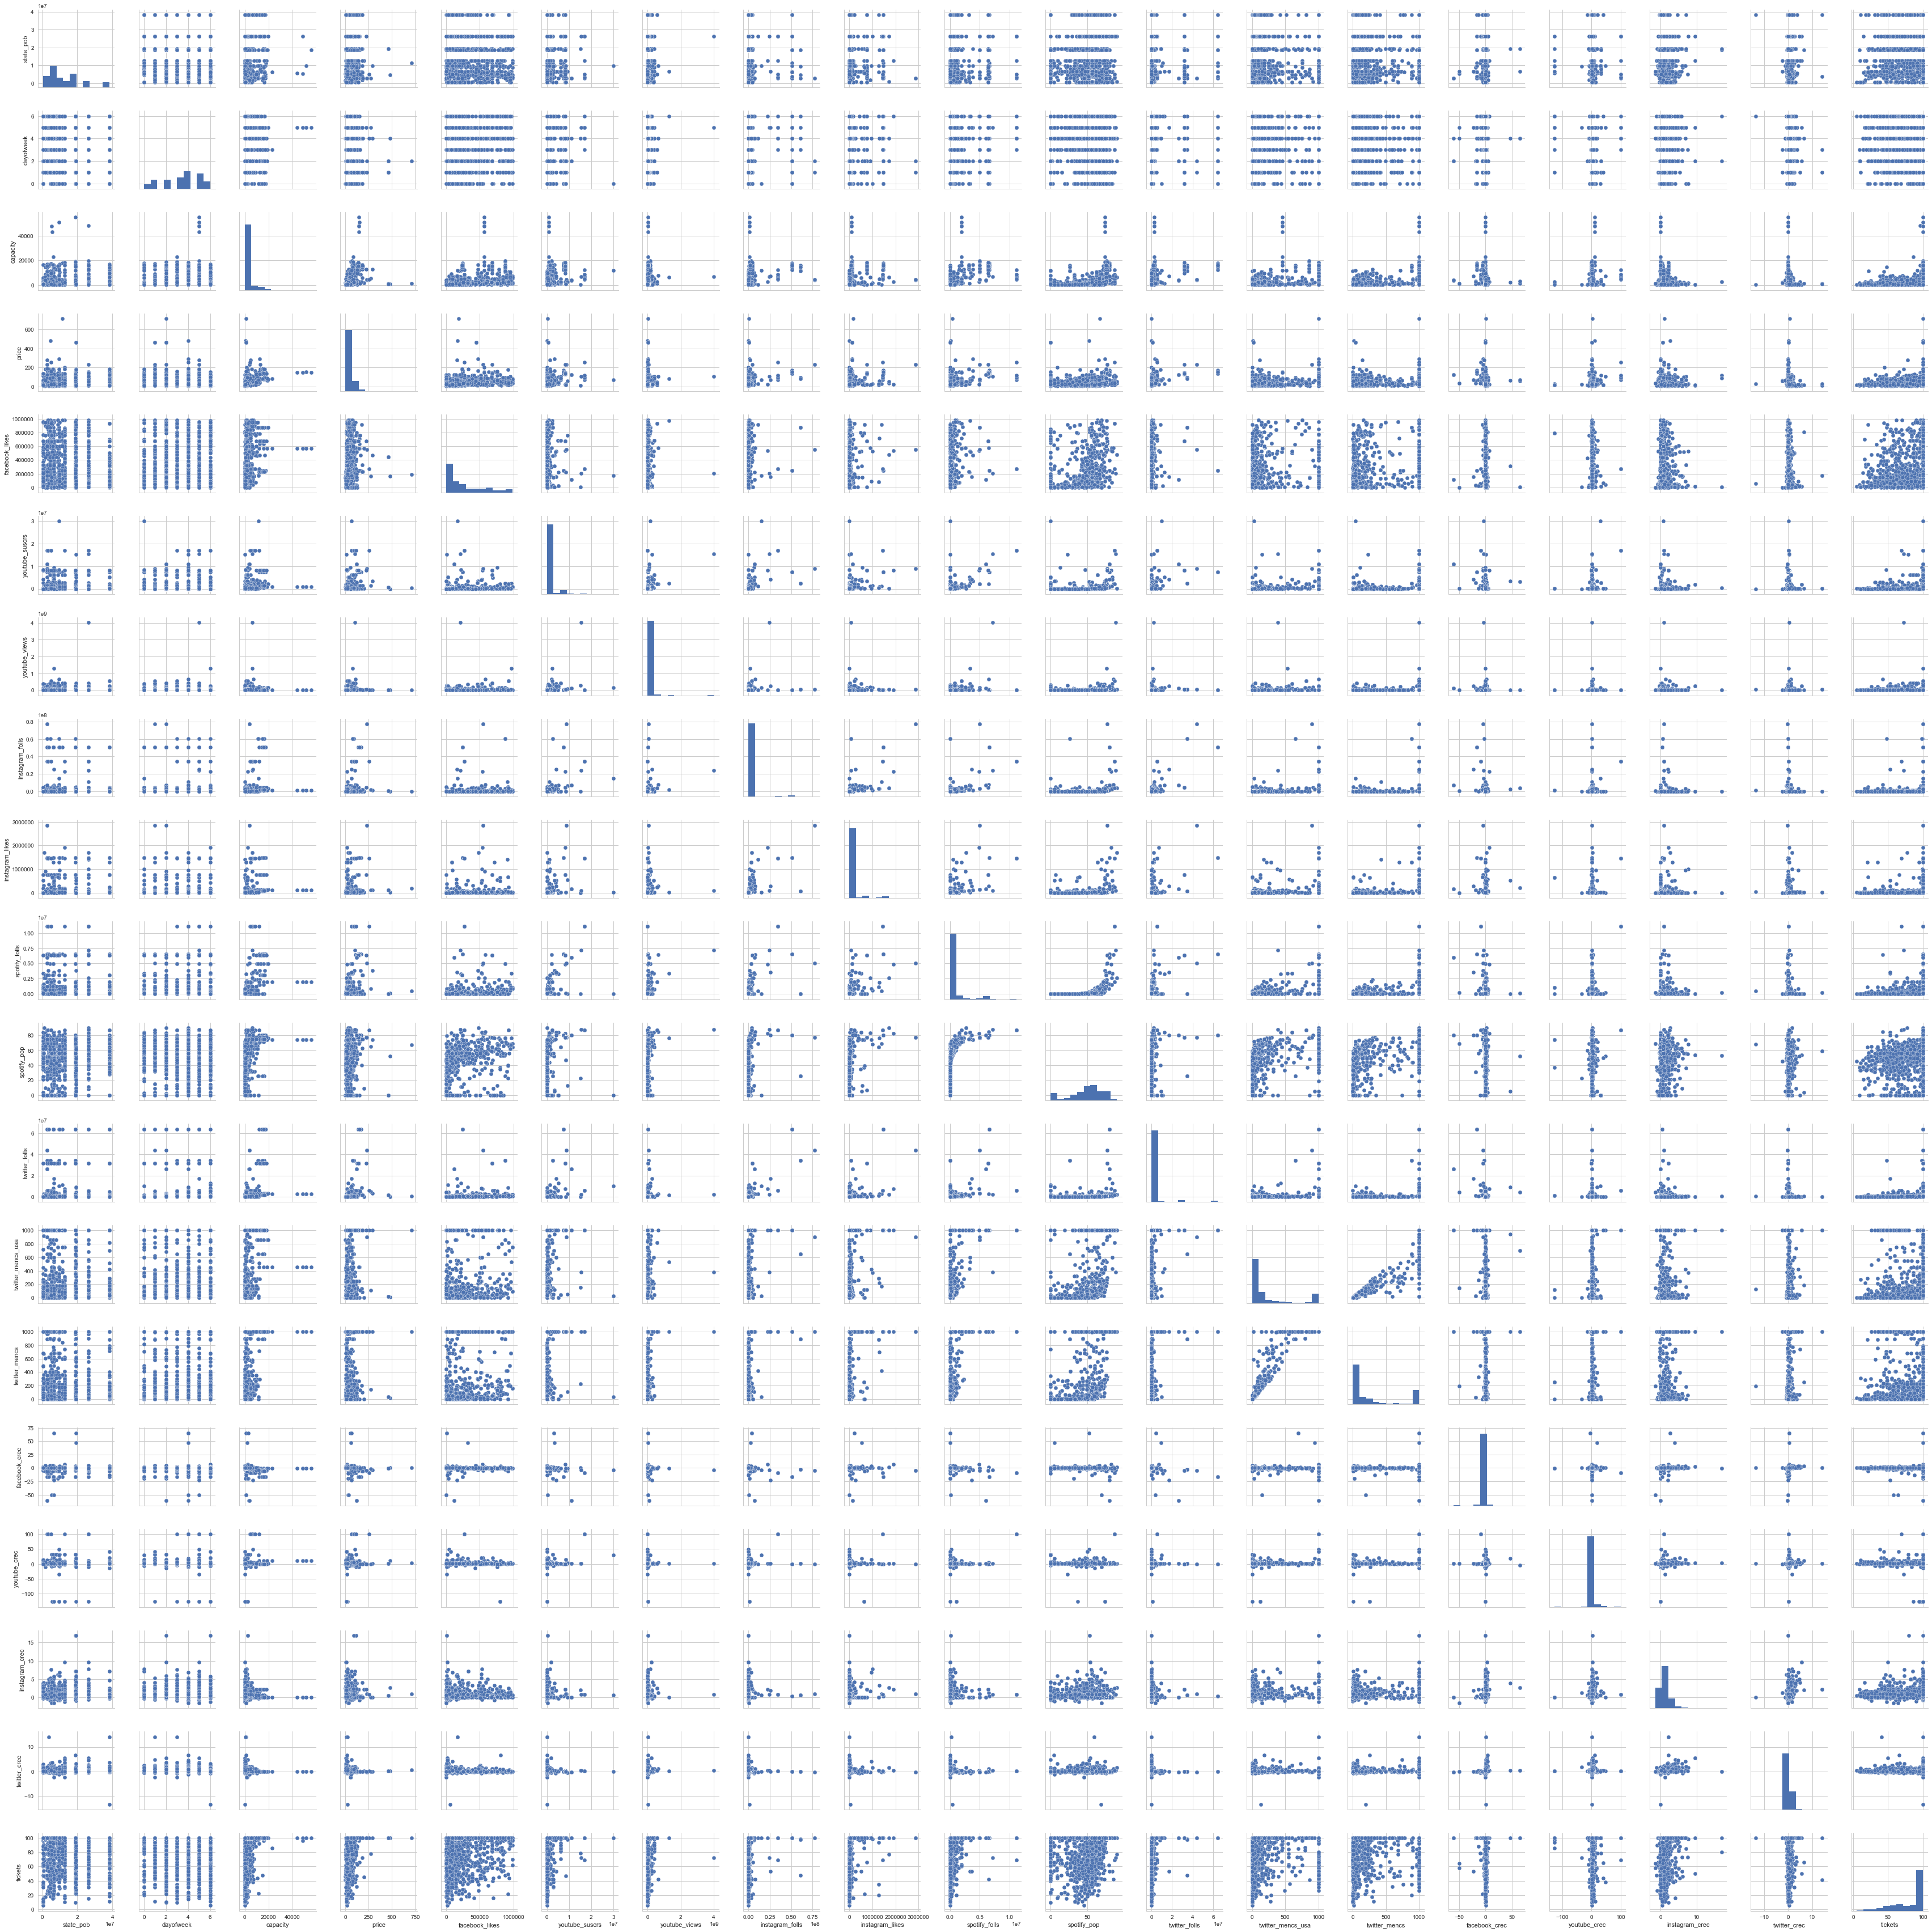

In [22]:
# grafico de dispersion entre variables

data_df = pd.DataFrame(Xy, columns=['state_pob', 'dayofweek', 'capacity', 'price', 'facebook_likes','youtube_suscrs','youtube_views','instagram_folls','instagram_likes','spotify_folls','spotify_pop','twitter_folls','twitter_mencs_usa','twitter_mencs','facebook_crec','youtube_crec','instagram_crec','twitter_crec','tickets'])
sns.set(style='whitegrid', context='notebook')
features_plot = data_df.columns
data_df[0:10]
sns.pairplot(data_df)#, kind='reg')#, size=2.0);
plt.tight_layout()

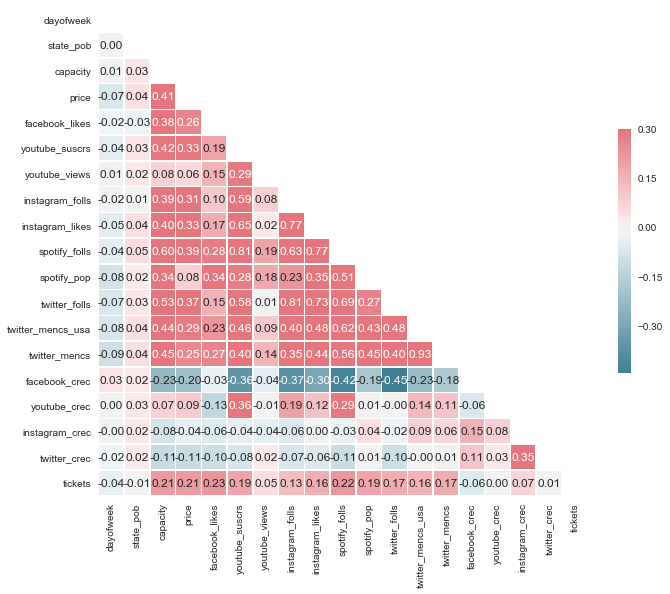

In [23]:
# correlacion entre variables

corr_vectors = Xy.corr()
mask = np.zeros_like(corr_vectors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_vectors, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

En base a la observacion de las variables, se puede apreciar que hay variables que estan poco correlacionadas con la venta de tickets. En particular, esto sucede con: <i>state_pob, dayofweek, twitter_mencs_usa, twitter_mencs, facebook_crec, instagram_crec</i> y <i>twitter_crec</i>, con una correlacion inferior al 10%.

## Modelo de regresion

A continuación se realiza el entrenamiento del modelo. Luego de probar con diversos algoritmos, se decidió utilizar <I>RandomForestRegressor</I>.

Para medir la efectividad del proceso, se implementó una medida del resultado considerando una categorización en clases de los datos y la prediccion, considerando un umbral para el valor de la variable dependiente. En este caso, se determinó que los valores mayores o iguales a 77% serían considerados un <b>resultado positivo</b>, y valores menores, un <b>resultado negativo</b>.

De esta manera, el sistema realiza el conteo de casos satisfactoriamente predichos, entregando un score de <B><I>accuracy</I></B>. Tambien se calculan los valores de R^2 (coeficiente de determinacion) y RMSE (raiz del error cuadratico medio).

In [24]:
# implementacion modelo, utilizando validacion cruzada

model = models[algorithm]

X=np.array(X)
predictions = []
y_list_all = []
predictions_all = []
r2s = []
rmses = []
scores = []

all_aciertos_positivo = 0; all_aciertos_negativo = 0
all_errores_positivo = 0; all_errores_negativo = 0

kf = KFold(n_splits=10,shuffle=True)
for k, (train, test) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train,:], X[test,:]
    y_train, y_test = y[train], y[test]
    model = models['randomforest']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = y_pred.copy()
    
    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    y_list = list(y_test)
    for k in range(0, len(predictions)):
        #print str(y_list[k]) + ' :',
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
            
        if y_list[k] >= threshold: sum_positivo += 1
        else: sum_negativo += 1
        if predictions[k] >= threshold: sum_predict_positivo += 1
        else: sum_predict_negativo += 1

    all_aciertos_positivo += aciertos_positivo
    all_aciertos_negativo += aciertos_negativo
    all_errores_positivo  += errores_positivo
    all_errores_negativo  += errores_negativo

    r2s.append(r2_score(y_list, predictions))
    rmses.append(np.sqrt(mean_squared_error(predictions, y_list)))
    scores.append(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    y_list_all.extend(y_list)
    predictions_all.extend(predictions)
    
    print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
    print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
    print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    df = pd.DataFrame({'real': y_list, 'prediction': predictions})    

print
print "R2s: ", np.mean(r2s)
print "RMSEs: ",np.mean(rmses)
print "scores: ", np.mean(scores)

print
conf = pd.DataFrame([[all_aciertos_positivo, all_errores_positivo], [all_errores_negativo, all_aciertos_negativo]], columns=['positivo', 'negativo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.27, RMSE: 20.71, SCORE: 90 / 125 = 0.72
R2: 0.4, RMSE: 18.09, SCORE: 91 / 125 = 0.728
R2: 0.26, RMSE: 21.95, SCORE: 82 / 125 = 0.656
R2: 0.12, RMSE: 19.49, SCORE: 82 / 124 = 0.661
R2: 0.25, RMSE: 19.3, SCORE: 89 / 124 = 0.718
R2: 0.24, RMSE: 22.85, SCORE: 92 / 124 = 0.742
R2: 0.22, RMSE: 18.23, SCORE: 89 / 124 = 0.718
R2: 0.21, RMSE: 20.75, SCORE: 79 / 124 = 0.637
R2: 0.32, RMSE: 19.82, SCORE: 93 / 124 = 0.75
R2: 0.29, RMSE: 20.24, SCORE: 89 / 124 = 0.718

R2s:  0.25680573293725334
RMSEs:  20.142688124848
scores:  0.7048



,positivo,negativo
positivo,606,207
negativo,160,270


Respecto a la predicción, se grafica su resultado, donde se muestran los valores reales versus las predicciones. En este gráfico se puede apreciar que el cuadrante superior-derecha muestra los casos positivos correctamente clasificados, lo mismo con el cuadrante inferior-izquierda, para los casos negativos. El resto de los casos son los erroneamente clasificados.

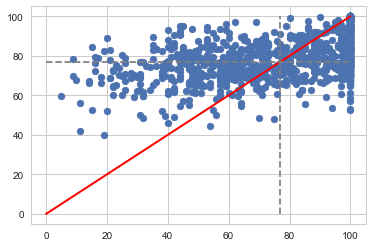

In [25]:
# grafico de dispersion de las predicciones

plt.scatter(y_list_all, predictions_all)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

## Recursive Feature Elimination

A continuacion, se prueba la eliminacion recursiva de caracteristicas, para construir un modelo con menos variables.

In [26]:
# inicializacion y ejecucion del modelo

from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
Xdf = pd.DataFrame(X)
print list(Xdf.columns.values)[:62]
print rfe.support_
y_pred = rfe.predict(X_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[False False False False False False False  True  True  True False False
  True  True  True  True  True False  True False False False False  True]


In [27]:
# calculo de errores y aciertos

sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
errores_positivo = 0; errores_negativo = 0
sum_positivo = 0; sum_negativo = 0
sum_predict_positivo = 0; sum_predict_negativo = 0
total_test = len(X_test)

y_list = list(y_test)
for k in range(0, len(y_pred)):
    sum += abs(y_pred[k] - y_list[k])
    if y_list[k] >= threshold and y_pred[k] >= threshold:
        aciertos_positivo += 1
    if y_list[k] >= threshold and y_pred[k] < threshold:
        errores_positivo += 1
    if y_list[k] < threshold and y_pred[k] < threshold:
        aciertos_negativo += 1
    if y_list[k] < threshold and y_pred[k] >= threshold:
        errores_negativo += 1
    if y_list[k] >= threshold:
        sum_positivo += 1
    else:
        sum_negativo += 1
    if y_pred[k] >= threshold:
        sum_predict_positivo += 1
    else:
        sum_predict_negativo += 1

In [28]:
# estadisticas del modelo

print
print "R2: " + str(round(r2_score(y_test, y_pred), 2))
print "RMSE: " + str(round(np.sqrt(mean_squared_error(y_pred, y_test)), 2))
print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
print "PRECISION: " + str(round(1.0 * aciertos_positivo / sum_predict_positivo, 3))
print "RECALL: " + str(round(1.0 * aciertos_positivo / sum_positivo, 3))
df = pd.DataFrame({'real': y_test, 'prediction': y_pred})
print "correlacion: " + str(round(df.corr()['real'][0], 2))
print "confusion-matrix:"
conf = pd.DataFrame([[errores_positivo, aciertos_positivo], [aciertos_negativo, errores_negativo]], columns=['negativo', 'positivo'])
conf.rename(index={0:'positivo', 1:'negativo'})


R2: 0.26
RMSE: 19.67
SCORE: 168 / 249 = 0.675
PRECISION: 0.747
RECALL: 0.723
correlacion: 0.51
confusion-matrix:


,negativo,positivo
positivo,43,112
negativo,56,38


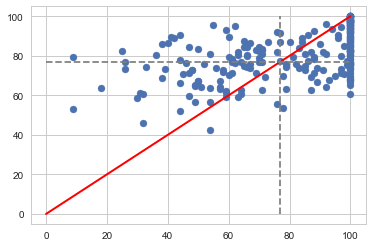

In [29]:
# grafico de dispersion de las predicciones

plt.scatter(y_test, y_pred)
plt.plot([0, 100], [0, 100], c='r', lw=2)
ax = plt.gca()
line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
ax.add_line(line_h)
ax.add_line(line_v)
plt.show()

# Pruebas con algunas variables

En base al analisis de variables realizado, ahora se eliminan algunas variables, generando un dataset mas reducido.
Tambien se prueban algunos metodos de normalizacion para las variables.

In [30]:
# nuevo armado del conjunto de variables

mapper = sp.DataFrameMapper([
    #('dayofweek', LabelBinarizer()),
    ([
    #'state_pob', 
    'capacity',
    'price', 
    'facebook_likes', 
    'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls',# 'twitter_mencs', 'twitter_mencs_usa', 
    'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'
    ], StandardScaler())
    #], Normalizer())
    #], MinMaxScaler())
    #], RobustScaler())
    ])
X = dataset[[
    #'dayofweek',
    #'state_pob', 
    'capacity',
    'price',
    'facebook_likes', 
    'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls',# 'twitter_mencs', 'twitter_mencs_usa', 
    'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'
    ]]
X = mapper.fit_transform(X)
y = dataset['tickets']

## Pruebas de algoritmos, con conjunto de test

Se separa el dataset en dos conjuntos: training y test, y se prueban diferentes algoritmos de regresion.


knn:
	R2: 0.18
	RMSE: 21.89
	SCORE: 175 / 249 = 0.703
   negativo  positivo
0        39       123
1        52        35


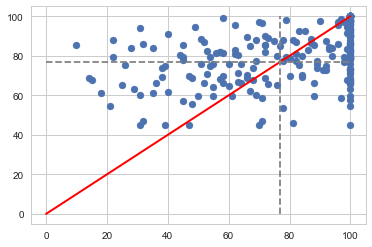

gradient:
	R2: 0.32
	RMSE: 20.05
	SCORE: 194 / 249 = 0.779
   negativo  positivo
0        29       132
1        62        26


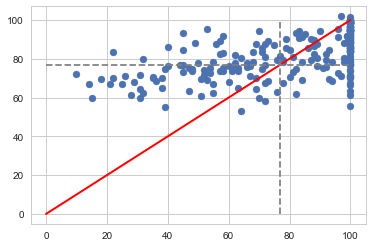

randomforest:
	R2: 0.36
	RMSE: 19.38
	SCORE: 189 / 249 = 0.759
   negativo  positivo
0        31       129
1        60        29


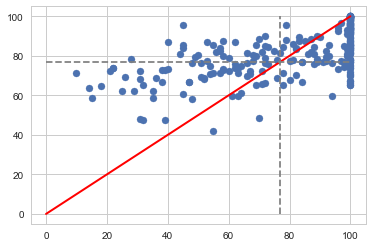

adaboost:
	R2: 0.17
	RMSE: 22.15
	SCORE: 169 / 249 = 0.679
   negativo  positivo
0        21        99
1        70        59


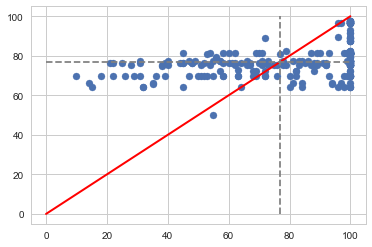

MLPRegressor:
	R2: 0.21
	RMSE: 21.51
	SCORE: 170 / 249 = 0.683
   negativo  positivo
0        34       113
1        57        45


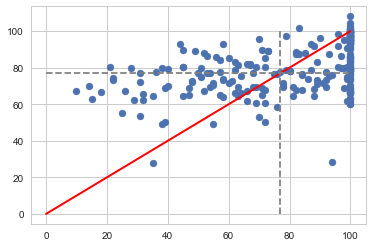

In [31]:
# probando diferentes algoritmos de regresion

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

models = {}
models['knn']          = KNeighborsRegressor()
models['adaboost']     = AdaBoostRegressor()
models['gradient']     = GradientBoostingRegressor(loss='huber', criterion='mse')
models['randomforest'] = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)
models['MLPRegressor'] = MLPRegressor(activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=900)
                 
for alg in models:
    print alg + ':'
    model = models[alg]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
    errores_positivo = 0; errores_negativo = 0
    sum_positivo = 0; sum_negativo = 0
    sum_predict_positivo = 0; sum_predict_negativo = 0
    total_test = len(X_test)
    #total_test = len(X)
    y_list = list(y_test)

    for k in range(0, len(predictions)):
        sum += abs(predictions[k] - y_list[k])
        if y_list[k] >= threshold and predictions[k] >= threshold:
            aciertos_positivo += 1
        if y_list[k] >= threshold and predictions[k] < threshold:
            errores_positivo += 1
        if y_list[k] < threshold and predictions[k] < threshold:
            aciertos_negativo += 1
        if y_list[k] < threshold and predictions[k] >= threshold:
            errores_negativo += 1
        if y_list[k] >= threshold:
            sum_positivo += 1
        else:
            sum_negativo += 1
        if predictions[k] >= threshold:
            sum_predict_positivo += 1
        else:
            sum_predict_negativo += 1

    print "\tR2: " + str(round(r2_score(y_list, predictions), 2))
    print "\tRMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2))
    print "\tSCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
    conf = pd.DataFrame([[errores_negativo, aciertos_positivo], [aciertos_negativo, errores_positivo]], columns=['negativo', 'positivo'])
    conf.rename(index={0:'negativo', 1:'positivo'})
    print conf
    
    # grafico de dispersion de las predicciones
    plt.scatter(y_list, predictions)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    #x0 = [0, 0, 30, 30]
    #y0 = [0, threshold, threshold, 0]
    #ax.fill(x0, y0, alpha=0.2)
    plt.show()

Del analisis realizado, se observa que los mejores resultados se obtienen con RandomForest. MLP y Adaboost tambien generan resultados interesantes.

## Modelo de regresion, con validacion cruzada

Ahora se realiza la validacion utilizando validacion cruzada, con 10 folds. La ejecucion se repite 3 veces, y se promedian sus resultados. En esta ejecucion se prueba con RandomForest, sin embargo, en el codigo tambien se encuentra definido el modelo para MLP y AdaBoost (comentado).

R2: 0.16, RMSE: 22.69, SCORE: 82 / 125 = 0.656
R2: 0.29, RMSE: 20.57, SCORE: 90 / 125 = 0.72
R2: 0.33, RMSE: 22.03, SCORE: 94 / 125 = 0.752
R2: 0.28, RMSE: 20.15, SCORE: 86 / 124 = 0.694
R2: 0.17, RMSE: 20.21, SCORE: 82 / 124 = 0.661
R2: 0.27, RMSE: 19.98, SCORE: 89 / 124 = 0.718
R2: 0.03, RMSE: 20.47, SCORE: 82 / 124 = 0.661
R2: 0.09, RMSE: 23.24, SCORE: 76 / 124 = 0.613
R2: 0.31, RMSE: 18.12, SCORE: 94 / 124 = 0.758
R2: 0.18, RMSE: 18.61, SCORE: 89 / 124 = 0.718

R2s:  0.21008070227818854
RMSEs:  20.606120631561353
scores:  0.6950999999999999
coef.corr:  0.4806635065038815
   negativo  positivo
0       176       610
1       254       203



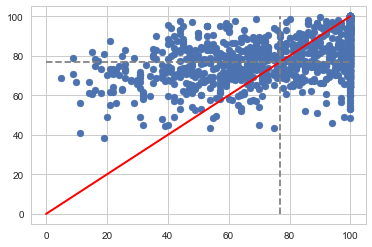

R2: 0.2, RMSE: 23.51, SCORE: 89 / 125 = 0.712
R2: 0.19, RMSE: 21.03, SCORE: 85 / 125 = 0.68
R2: 0.22, RMSE: 22.32, SCORE: 84 / 125 = 0.672
R2: 0.25, RMSE: 20.08, SCORE: 89 / 124 = 0.718
R2: 0.06, RMSE: 19.55, SCORE: 87 / 124 = 0.702
R2: 0.29, RMSE: 19.87, SCORE: 84 / 124 = 0.677
R2: 0.21, RMSE: 21.97, SCORE: 92 / 124 = 0.742
R2: 0.23, RMSE: 19.95, SCORE: 83 / 124 = 0.669
R2: 0.3, RMSE: 17.77, SCORE: 95 / 124 = 0.766
R2: 0.29, RMSE: 19.35, SCORE: 88 / 124 = 0.71

R2s:  0.22460201091173415
RMSEs:  20.538665299221048
scores:  0.7048
coef.corr:  0.4849858290252697
   negativo  positivo
0       172       618
1       258       195



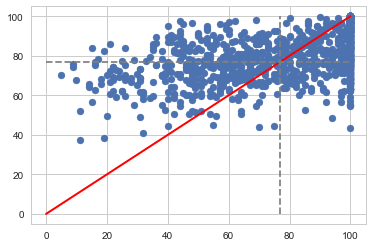

R2: 0.24, RMSE: 20.16, SCORE: 91 / 125 = 0.728
R2: 0.33, RMSE: 17.01, SCORE: 91 / 125 = 0.728
R2: 0.2, RMSE: 24.78, SCORE: 83 / 125 = 0.664
R2: 0.31, RMSE: 17.55, SCORE: 92 / 124 = 0.742
R2: 0.34, RMSE: 18.36, SCORE: 95 / 124 = 0.766
R2: 0.15, RMSE: 22.42, SCORE: 83 / 124 = 0.669
R2: 0.1, RMSE: 21.51, SCORE: 83 / 124 = 0.669
R2: 0.17, RMSE: 20.91, SCORE: 83 / 124 = 0.669
R2: 0.16, RMSE: 21.31, SCORE: 84 / 124 = 0.677
R2: 0.29, RMSE: 21.15, SCORE: 87 / 124 = 0.702

R2s:  0.22871705077815047
RMSEs:  20.516479527991358
scores:  0.7013999999999999
coef.corr:  0.48301696085617457
   negativo  positivo
0       171       613
1       259       200



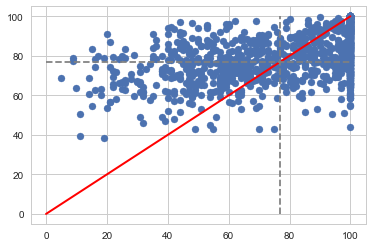

---------------------------------------------
RESUMEN:
r2: 0.22113325465602438
rsme: 20.553755152924587
score: 0.7004333333333332


,negativo,positivo
positivo,173.0,613.666667
negativo,257.0,199.333333


In [32]:
# implementacion modelo, utilizando validacion cruzada... se ejecuta 3 veces, con 10 folds.

threshold = 77
all_r2 = []
all_rsme = []
all_score = []
all_aciertos_pos = []
all_aciertos_neg = []
all_errores_pos = []
all_errores_neg = []

for k in range(0, 3):
    r2s = []
    rmses =[]
    scores = []
    X=np.array(X)
    predictions_all = []
    aciertos_pos = []; aciertos_neg = []; errores_pos = []; errores_neg = []
    sum_ylist = 0; sum_pred = 0
    p = 0
    yy = []
    xx = []
    y_list_all = []
    X_list_all = []

    kf = KFold(n_splits=10, shuffle=True)
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        model = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, n_jobs=4)
        #model = MLPRegressor(activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=900)
        #model = AdaBoostRegressor(base_estimator=None)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions = y_pred.copy()

        sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
        errores_positivo = 0; errores_negativo = 0
        sum_positivo = 0; sum_negativo = 0
        sum_predict_positivo = 0; sum_predict_negativo = 0
        total_test = len(X_test)
        X_list = list(X_test)
        y_list = list(y_test)

        for k in range(0, len(predictions)):
            sum += abs(predictions[k] - y_list[k])
            if y_list[k] >= threshold and predictions[k] >= threshold:
                aciertos_positivo += 1
            if y_list[k] >= threshold and predictions[k] < threshold:
                errores_positivo += 1
            if y_list[k] < threshold and predictions[k] < threshold:
                aciertos_negativo += 1
            if y_list[k] < threshold and predictions[k] >= threshold:
                errores_negativo += 1
            if y_list[k] >= threshold:
                sum_positivo += 1
            else:
                sum_negativo += 1
            if predictions[k] >= threshold:
                sum_predict_positivo += 1
            else:
                sum_predict_negativo += 1

        print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
        print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
        print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
        df = pd.DataFrame({'real': y_list, 'prediction': predictions})

        aciertos_pos.append(aciertos_positivo)
        aciertos_neg.append(aciertos_negativo)
        errores_pos.append(errores_positivo)
        errores_neg.append(errores_negativo)

        r2s.append(r2_score(y_list, predictions))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        scores.append(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))

        predictions_all.extend(predictions)
        X_list_all.extend(X_list)
        y_list_all.extend(y_list)

        sum_ylist += np.sum(y_list)
        sum_pred  += np.sum(predictions)

        p += 1

    print
    print "R2s: ", np.mean(r2s)
    print "RMSEs: ",np.mean(rmses)
    print "scores: ", np.mean(scores)
    print "coef.corr: " , np.corrcoef(y_list_all, predictions_all)[0][1]
    conf = pd.DataFrame([[np.sum(errores_neg), np.sum(aciertos_pos)], [np.sum(aciertos_neg), np.sum(errores_pos)]], columns=['negativo', 'positivo'])
    conf.rename(index={0:'negativo', 1:'positivo'})
    print conf
    print

    #for i in range(0, len(y_list_all)):
    #    if y_list_all[i] == 100 and predictions_all[i] < 60:
    #        print str(X_list_all[i]) + ' = ' + str(y_list_all[i]) + ' / ' + str(predictions_all[i])
    
    plt.scatter(y_list_all, predictions_all)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    #x0 = [0, 0, 35, 35]
    #y0 = [0, threshold, threshold, 0]
    #ax.fill(x0, y0, alpha=0.2)
    plt.show()
    
    all_r2.append(np.mean(r2s))
    all_rsme.append(np.mean(rmses))
    all_score.append(np.mean(scores))
    all_aciertos_pos.append(np.sum(aciertos_pos))
    all_aciertos_neg.append(np.sum(aciertos_neg))
    all_errores_pos.append(np.sum(errores_pos))
    all_errores_neg.append(np.sum(errores_neg))

print '---------------------------------------------'
print 'RESUMEN:'
print "r2: " + str(np.mean(all_r2))
print "rsme: " + str(np.mean(all_rsme))
print "score: " + str(np.mean(all_score))

conf = pd.DataFrame([[np.mean(all_errores_neg), np.mean(all_aciertos_pos)], [np.mean(all_aciertos_neg), np.mean(all_errores_pos)]], columns=['negativo', 'positivo'])
conf.rename(index={0:'positivo', 1:'negativo'})

In [33]:
# despliegue como clases

df = pd.DataFrame(y_list_all)
df.columns = ['tickets']
df.insert(loc=1, column='predictions', value=np.round(predictions_all))
y_label = copy.copy(y_list_all)
type(y_label)
for k in range(0, len(y_label)):
    if y_label[k] >= threshold:
        y_label[k] = 'positivo'
    else:
        y_label[k] = 'negativo'

predictions_label = pd.Series(predictions_all)
predictions_label[predictions_label>=threshold] = 'positivo'
predictions_label[predictions_label<threshold] = 'negativo'

df1 = pd.DataFrame(y_label)
df1.insert(loc=1, column='predictions', value=predictions_label)

df.insert(loc=2, column='tickets-class', value=df1[0].tolist())
df.insert(loc=3, column='predictions-class', value=df1['predictions'].tolist())
df.head()

,tickets,predictions,tickets-class,predictions-class
0,98,78.0,positivo,positivo
1,55,70.0,negativo,negativo
2,100,70.0,positivo,negativo
3,100,100.0,positivo,positivo
4,100,69.0,positivo,negativo
